In [1]:
#Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from fbprophet import Prophet

from sklearn.linear_model import HuberRegressor, LinearRegression, Ridge

from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

from skopt import BayesSearchCV, gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt import dump

import lightgbm as lgb

from sklearn.pipeline import make_pipeline, make_union
#import category_encoders as en

from sklearn.ensemble import RandomForestRegressor

In [2]:
#Read test and train data - Please change this accordingly
train = pd.read_csv("../data/train_aWnotuB.csv", parse_dates=['DateTime'])
test = pd.read_csv("../data/test_BdBKkAj.csv",  parse_dates=['DateTime'])
sample_sub = pd.read_csv("../data/sample_submission_EZmX9uE.csv")

print(train.shape, test.shape, sample_sub.shape)

(48120, 4) (11808, 3) (0, 2)


In [3]:
#Split data by junction values
def split_df(df):
    all_df = []
    for jn in df.Junction.unique():
        df_sub = df.loc[df.Junction == jn].set_index('DateTime')
        #print(jn)
        all_df.append(df_sub)
    return all_df

In [4]:
#Function to get features from date 
def get_datetime_feats(df):
    df['hourofday'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['week'] = df['DateTime'].dt.week

In [5]:
#generate features related to date-time for all records in train and test
get_datetime_feats(train)
get_datetime_feats(test)

In [6]:
#Split data into individual time series
train1, train2, train3, train4 = split_df(train)
test1, test2, test3, test4 = split_df(test)

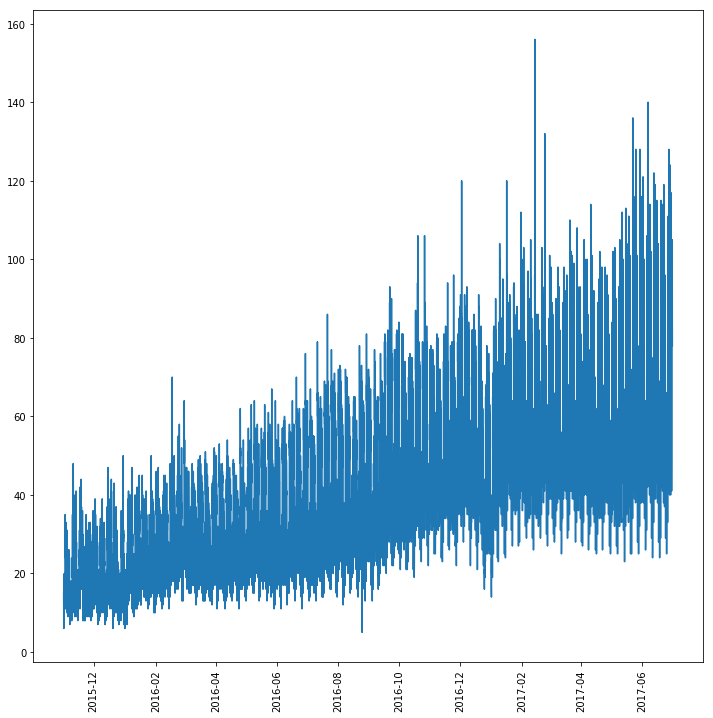

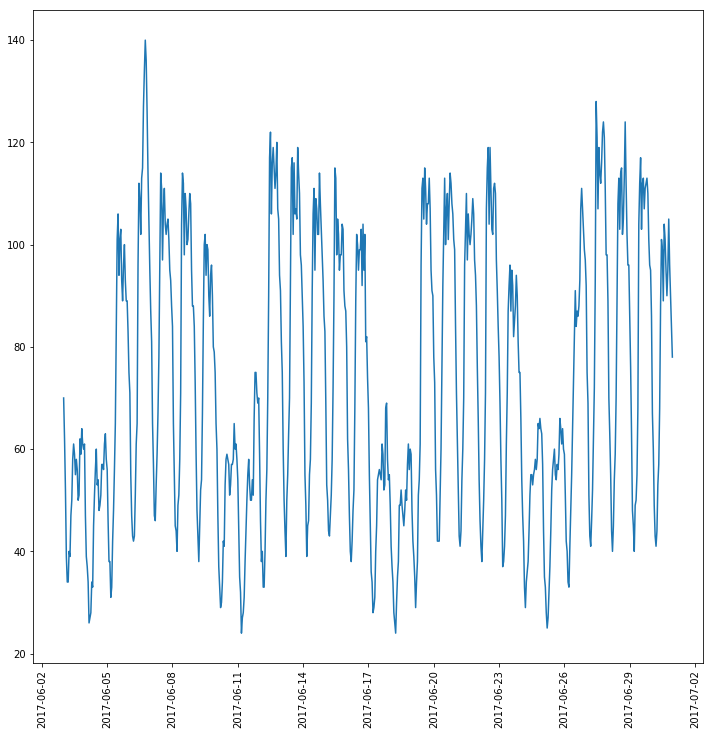

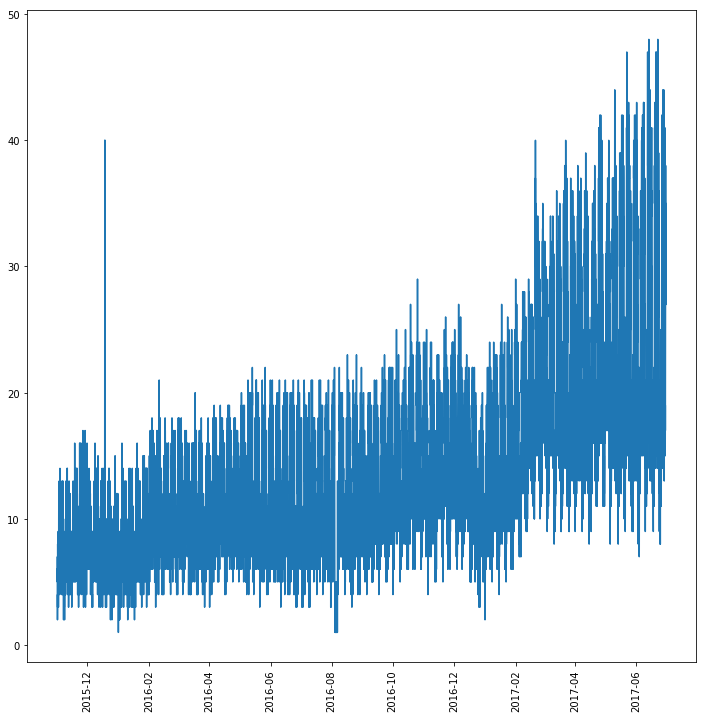

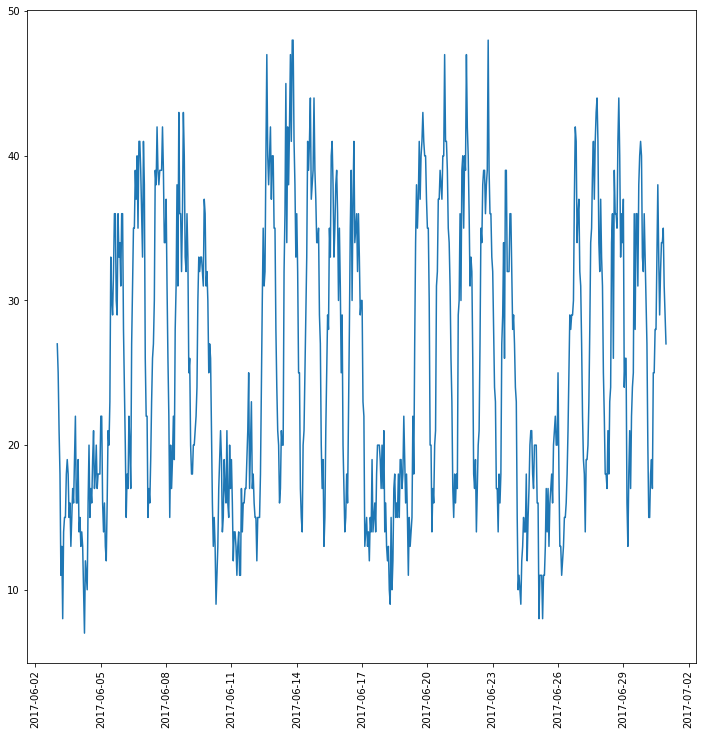

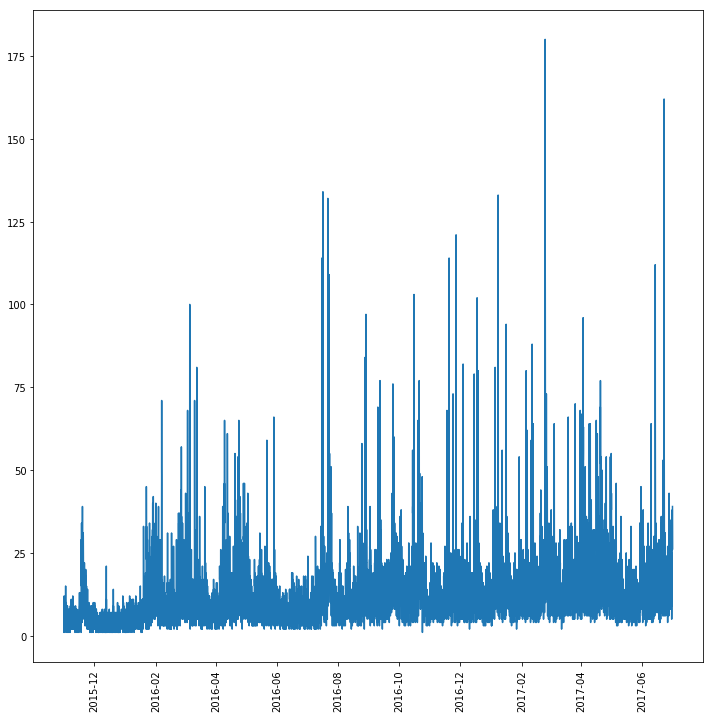

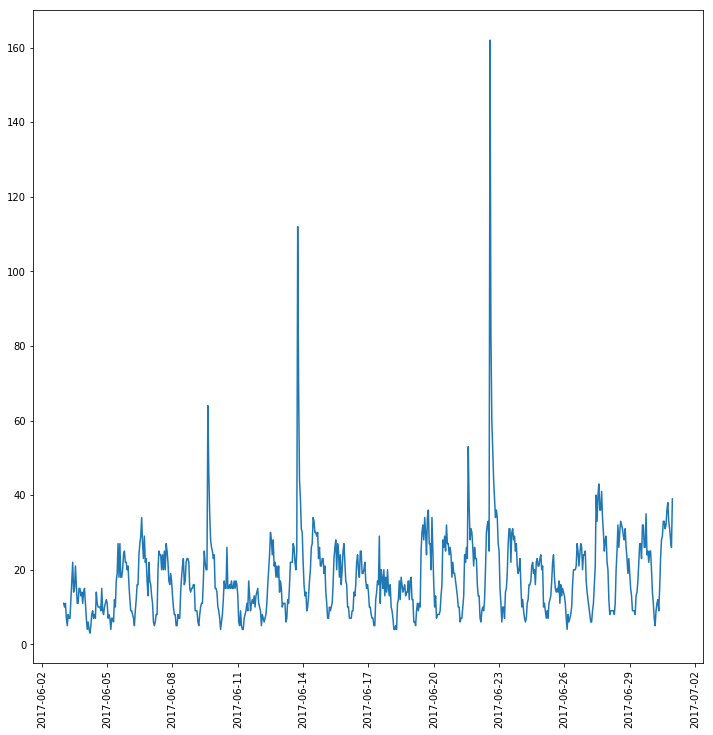

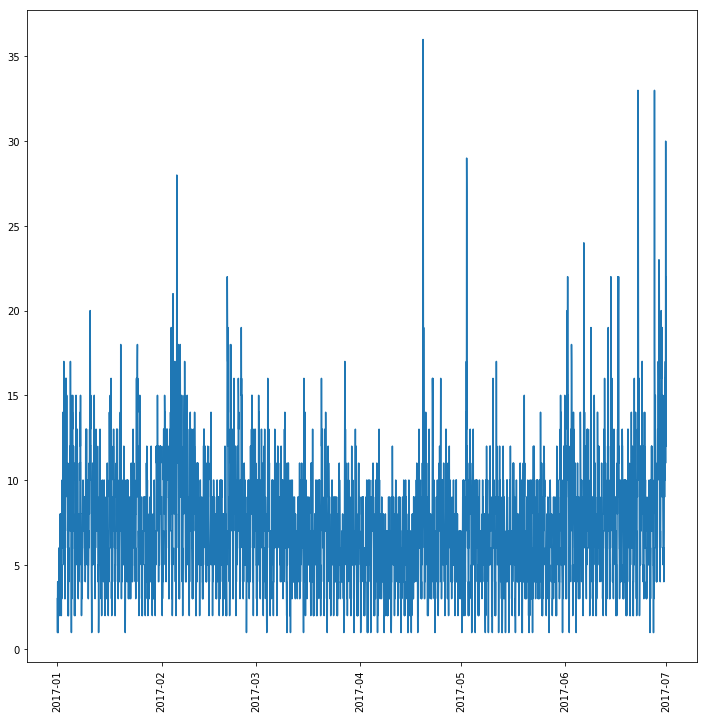

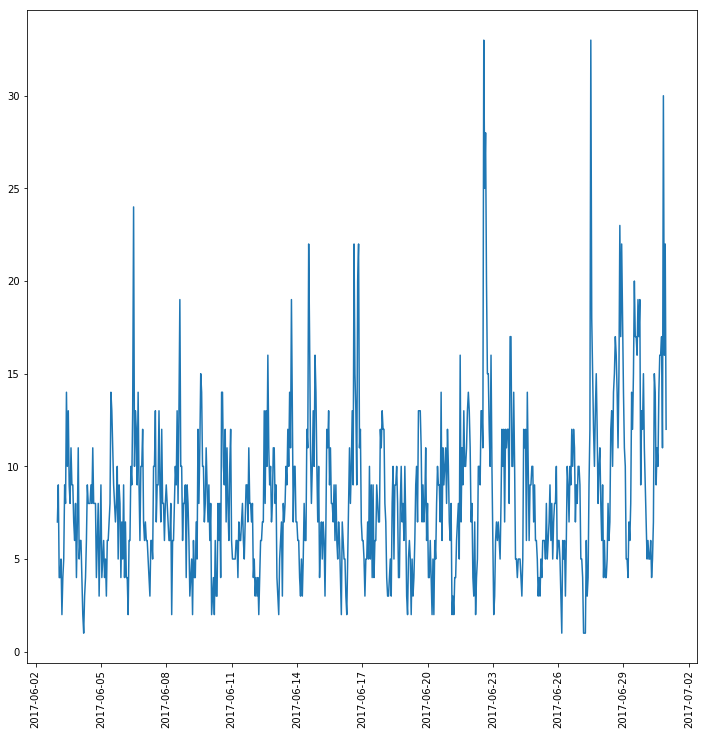

In [7]:
#Lets plot each of the timeseries
def plot_ts(df):
    #Whole series
    plt.figure(figsize=(12,12))
    plt.plot(df.Vehicles)
    plt.xticks(rotation=90)
    plt.show()
    
    #Last 4 weeks
    plt.figure(figsize=(12,12))
    plt.plot(df.Vehicles.iloc[-7*4*24:])
    plt.xticks(rotation=90)
    plt.show()
    
for df in [train1, train2, train3, train4]:
    plot_ts(df)


### Observation:
* **Very strong relationship to day oh hour**
* **Good segregation between day of week**
* **Additionally, Junction1 and Junction2 have pretty strong trend. Need to remove it**

Also, for time series we need to careful about window of observations we pick for training our model, as there is heteroscedasticity present in data (Junction 1 and 2)

May be try different windows to see which gives best results.

One other way to counter window effect could be to include a counter for day as a variable so that some trees automatically pick major shift in trend(as in Junction2) in pur ensemble of trees

In [8]:
#Function Day and week counter (pseudo subsampling)
def get_dayweekcounter(train, test):
    train['day_counter'] = np.cumsum(np.abs(train['day'] - train['day'].shift()) > 0)
    test['day_counter'] = train['day_counter'].max() + np.cumsum(np.abs(test['day'] - test['day'].shift()) > 0)
    
    train['week_counter'] = np.cumsum(np.abs(train['week'] - train['week'].shift()) > 0)
    test['week_counter'] = train['week_counter'].max() + np.cumsum(np.abs(test['week'] - test['week'].shift()) > 0)

In [9]:
#Remove outliers - don't want one off things biasing our results
for df in [train1, train2, train3, train4]:
    df['Vehicles'] = df['Vehicles'].clip(df['Vehicles'].quantile(0.001), df['Vehicles'].quantile(0.999))

# Detrend time series
* We can either fit linear regression or use differencing to detrend series
* Here, we fit linear regression

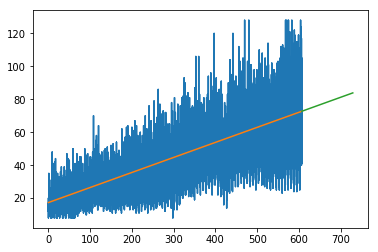

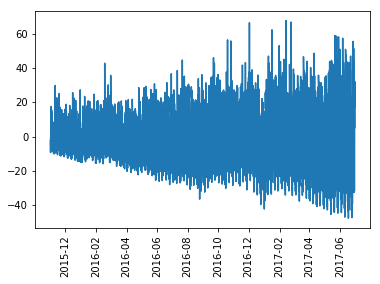

In [10]:
get_dayweekcounter(train1, test1)
lr1 = Ridge()
lr1.fit(train1[['day_counter']], train1['Vehicles'])
train1['trend'] = lr1.predict(train1[['day_counter']])
test1['trend'] = lr1.predict(test1[['day_counter']])

plt.plot(train1.day_counter, train1.Vehicles)
plt.plot(train1.day_counter, train1.trend)
plt.plot(test1.day_counter, test1.trend)
plt.show()

train1['residual'] = train1['Vehicles'] - train1['trend']
#test1['residual'] = test1['Vehicles'] - test1['trend']
plt.plot(train1.residual)
plt.xticks(rotation=90)
plt.show()

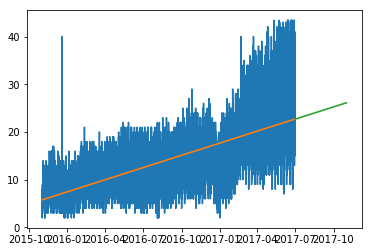

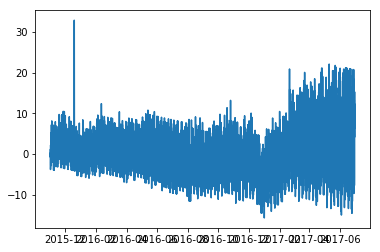

In [11]:
get_dayweekcounter(train2, test2)
lr2 = Ridge()

#We add square term as time series seem to follow a quadratic nature(WARNING: MIGHT OVERFIT)
#train2['day_counter_sqr'] = train2['day_counter']**2
#test2['day_counter_sqr'] = test2['day_counter']**2

lr2.fit(train2[['day_counter']], train2['Vehicles'])
train2['trend'] = lr2.predict(train2[['day_counter']])
test2['trend'] = lr2.predict(test2[['day_counter']])

plt.plot(train2.Vehicles)
plt.plot(train2.trend)
plt.plot(test2.trend)
plt.show()

train2['residual'] = train2['Vehicles'] - train2['trend']
#test1['residual'] = test1['Vehicles'] - test1['trend']
plt.plot(train2.residual)
plt.show()

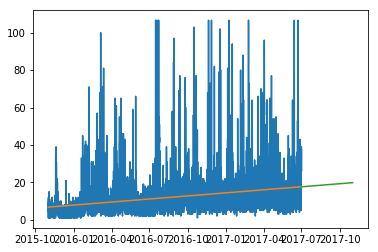

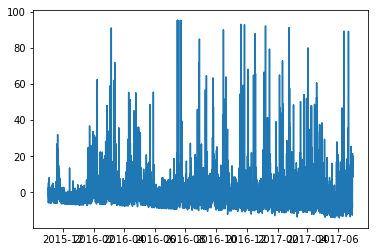

In [12]:
get_dayweekcounter(train3, test3)
lr3 = HuberRegressor(epsilon=1.5) #We use Huber regressor because of lot of outliers
lr3.fit(train3[['day_counter']], train3['Vehicles'])
train3['trend'] = lr3.predict(train3[['day_counter']])
test3['trend'] = lr3.predict(test3[['day_counter']])

plt.plot(train3.Vehicles)
plt.plot(train3.trend)
plt.plot(test3.trend)
plt.show()

train3['residual'] = train3['Vehicles'] - train3['trend']
#test1['residual'] = test1['Vehicles'] - test1['trend']
plt.plot(train3.residual)
plt.show()

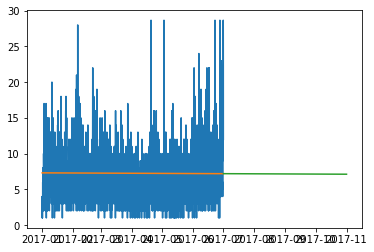

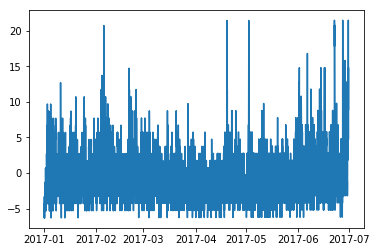

In [13]:
get_dayweekcounter(train4, test4)
lr4 = Ridge()
lr4.fit(train4[['day_counter']], train4['Vehicles'])
train4['trend'] = lr4.predict(train4[['day_counter']])
test4['trend'] = lr4.predict(test4[['day_counter']])

plt.plot(train4.Vehicles)
plt.plot(train4.trend)
plt.plot(test4.trend)
plt.show()

train4['residual'] = train4['Vehicles'] - train4['trend']
#test1['residual'] = test1['Vehicles'] - test1['trend']
plt.plot(train4.residual)
plt.show()

# Detrend and fit GBM on residuals

In [14]:
train_new = pd.concat([train1, train2, train3, train4]).reset_index()
test_new = pd.concat([test1, test2, test3, test4]).reset_index()
train_new.head()

,DateTime,Junction,Vehicles,ID,hourofday,dayofweek,day,dayofyear,month,year,week,day_counter,week_counter,trend,residual
0,2015-11-01 00:00:00,1,15.0,20151101001,0,6,1,305,11,2015,44,0,0,17.339529,-2.339529
1,2015-11-01 01:00:00,1,13.0,20151101011,1,6,1,305,11,2015,44,0,0,17.339529,-4.339529
2,2015-11-01 02:00:00,1,10.0,20151101021,2,6,1,305,11,2015,44,0,0,17.339529,-7.339529
3,2015-11-01 03:00:00,1,8.0,20151101031,3,6,1,305,11,2015,44,0,0,17.339529,-9.339529
4,2015-11-01 04:00:00,1,9.0,20151101041,4,6,1,305,11,2015,44,0,0,17.339529,-8.339529


# Validation strategy

Pick 3 validation sets
* Pick last 4 months from train data (same as test)
* Last 2 months for more weightage to recent effects

In [15]:
#Get validation lists - March-June, Jan-June, May-June 

tr1, val1 = train_new.loc[train_new['DateTime'] < pd.to_datetime('2017/03/01')].index, \
            train_new.loc[train_new['DateTime'] >= pd.to_datetime('2017/03/01')].index
    
#tr2, val2 = train_new.loc[train_new['DateTime'] < pd.to_datetime('2017/01/01')].index, \
#            train_new.loc[train_new['DateTime'] >= pd.to_datetime('2017/01/01')].index
    
tr3, val3 = train_new.loc[train_new['DateTime'] < pd.to_datetime('2017/05/01')].index, \
            train_new.loc[train_new['DateTime'] >= pd.to_datetime('2017/05/01')].index
    
cvlist = [[tr1, val1], [tr3, val3]]

In [16]:
#Only pick useful features (check using cv)
feats = ['Junction', 'hourofday', 'dayofweek','day_counter', 'week_counter', 'day','dayofyear', 'week']
X = train_new[feats]
y = train_new['residual']
X_test = test_new[feats]

In [17]:
#Define sklearn compatible eval metric
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
rmse_sk = make_scorer(rmse, False)

In [18]:
#Set up hyperparameter space for lightgbm optimization
def optimize_lightgbm(est, X, y, X_test, cvlist, weight_array, save_path="../utility/"):
    space  = [('regression', 'huber'),             # Objective
              (200, 1000),                           # n_estimators
              (7, 127),                              # num_leaves
              (0.4, 1),                            # colsample_bytree
              (0.4, 1),                            # subsample
              (20, 500),                             # min_child_samples
              (0, 1)]                               # alpha
    

    def objective(params):
        objective, n_estimators, num_leaves, colsample_bytree, subsample, min_child_samples, reg_alpha = params
        lgb_params = {
        'objective':objective,
        'n_estimators': n_estimators,
        'num_leaves': num_leaves,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'min_child_samples': min_child_samples,
        'reg_alpha': reg_alpha 
        }

        print("parameters...................",params)
        scores = cross_val_score(est.set_params(**lgb_params), X, y, cv=cvlist, scoring=rmse_sk, verbose=1,
                                fit_params={'sample_weight':weight_array})
        print("scores........................",scores)
        #preds_test = est.set_params(**lgb_params).fit(X, y).predict_proba_corr(X_test)
        #preds_dict = {'params':lgb_params, 'train_preds': preds, 'test_preds':preds_test}
        #filepath = os.path.join(save_path, str(time.time()))
        #with open(filepath, "wb") as f:
        #    pickle.dump(preds_dict, f)
        #print("Saved..............:", filepath)
        return -1* np.mean(scores)

    res = gp_minimize(objective,                  # the function to minimize
                      space,                          # the bounds on each dimension of x
                      acq_func="EI",                  # the acquisition function
                      n_calls=30,                     # the number of evaluations of f 
                      n_random_starts=10,             # the number of random initialization points
                      random_state=1,
                     verbose=True) 
    
    return res

In [19]:
print("Performing hyperparameter optimization for lgb: Likely overfitting")
res_lgb = optimize_lightgbm(lgb.LGBMRegressor(learning_rate=0.01,
                                        max_depth = -1), X, y, X_test, cvlist, train_new['week_counter'])

Performing hyperparameter optimization for lgb: Likely overfitting
Iteration No: 1 started. Evaluating function at random point.
parameters................... ['regression', 776, 7, 0.58139954357910395, 0.48805353449026789, 64, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished


scores........................ [ -9.7094855  -10.10795043]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5946
Function value obtained: 9.9087
Current minimum: 9.9087
Iteration No: 2 started. Evaluating function at random point.
parameters................... ['regression', 517, 72, 0.65151670864197697, 0.81113170023805581, 118, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s finished


scores........................ [-7.77415135 -8.23564321]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3808
Function value obtained: 8.0049
Current minimum: 8.0049
Iteration No: 3 started. Evaluating function at random point.
parameters................... ['regression', 736, 57, 0.73521389706745111, 0.48423216315714029, 115, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s finished


scores........................ [-7.49244557 -7.87162423]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.3052
Function value obtained: 7.6820
Current minimum: 7.6820
Iteration No: 4 started. Evaluating function at random point.
parameters................... ['huber', 451, 90, 0.92583349137762316, 0.93676399810230848, 61, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s finished


scores........................ [-8.25559912 -7.84515751]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.4958
Function value obtained: 8.0504
Current minimum: 7.6820
Iteration No: 5 started. Evaluating function at random point.
parameters................... ['regression', 903, 19, 0.65266457500303132, 0.97473371809030129, 276, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s finished


scores........................ [-7.41569375 -7.92708854]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.8595
Function value obtained: 7.6714
Current minimum: 7.6714
Iteration No: 6 started. Evaluating function at random point.
parameters................... ['regression', 749, 107, 0.41097296640651509, 0.85008658896698064, 495, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s finished


scores........................ [-8.66081559 -9.06383482]
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.5397
Function value obtained: 8.8623
Current minimum: 7.6714
Iteration No: 7 started. Evaluating function at random point.
parameters................... ['regression', 831, 19, 0.66873611570554314, 0.94515730185585745, 161, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s finished


scores........................ [-7.45651609 -8.16635314]
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.6393
Function value obtained: 7.8114
Current minimum: 7.6714
Iteration No: 8 started. Evaluating function at random point.
parameters................... ['regression', 215, 88, 0.52697686960003542, 0.55932799562333579, 256, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


scores........................ [ -9.59355422 -10.7842664 ]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.2315
Function value obtained: 10.1889
Current minimum: 7.6714
Iteration No: 9 started. Evaluating function at random point.
parameters................... ['huber', 317, 78, 0.81985501601255883, 0.46140065729669555, 219, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


scores........................ [-7.56097106 -8.14013408]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 1.9082
Function value obtained: 7.8506
Current minimum: 7.6714
Iteration No: 10 started. Evaluating function at random point.
parameters................... ['regression', 240, 71, 0.79827678713187344, 0.70893346723498518, 473, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished


scores........................ [-8.09342443 -8.75874686]
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.9098
Function value obtained: 8.4261
Current minimum: 7.6714
Iteration No: 11 started. Searching for the next optimal point.
parameters................... ['regression', 931, 7, 1.0, 1.0, 20, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s finished


scores........................ [-7.50507172 -8.33134873]
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 2.2062
Function value obtained: 7.9182
Current minimum: 7.6714
Iteration No: 12 started. Searching for the next optimal point.
parameters................... ['regression', 441, 29, 1.0, 0.59867566245551718, 20, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished


scores........................ [-8.31549764 -7.83254328]
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 2.3117
Function value obtained: 8.0740
Current minimum: 7.6714
Iteration No: 13 started. Searching for the next optimal point.
parameters................... ['regression', 877, 62, 0.40000000000000002, 1.0, 500, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s finished


scores........................ [-8.5359817  -8.91980431]
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 5.4288
Function value obtained: 8.7279
Current minimum: 7.6714
Iteration No: 14 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 7, 0.40000000000000002, 0.40000000000000002, 20, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s finished


scores........................ [-8.88009452 -9.1375342 ]
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.4297
Function value obtained: 9.0088
Current minimum: 7.6714
Iteration No: 15 started. Searching for the next optimal point.
parameters................... ['huber', 200, 127, 0.67182032130278913, 0.73994638729477336, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished


scores........................ [-8.99561147 -9.91769338]
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.5712
Function value obtained: 9.4567
Current minimum: 7.6714
Iteration No: 16 started. Searching for the next optimal point.
parameters................... ['regression', 867, 94, 0.67182285335731295, 0.89619393524901014, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s finished


scores........................ [-7.37748937 -7.73651909]
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 4.9926
Function value obtained: 7.5570
Current minimum: 7.5570
Iteration No: 17 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 7, 0.70191082704229246, 1.0, 20, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s finished


scores........................ [-7.98431777 -8.61272404]
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.3464
Function value obtained: 8.2985
Current minimum: 7.5570
Iteration No: 18 started. Searching for the next optimal point.
parameters................... ['regression', 215, 111, 0.70955884044886353, 0.40000000000000002, 407, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished


scores........................ [-8.97719181 -9.69659314]
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.4700
Function value obtained: 9.3369
Current minimum: 7.5570
Iteration No: 19 started. Searching for the next optimal point.
parameters................... ['regression', 810, 90, 0.64552178090429357, 0.99370062751186172, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s finished


scores........................ [-7.42454568 -7.79576015]
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 5.4719
Function value obtained: 7.6102
Current minimum: 7.5570
Iteration No: 20 started. Searching for the next optimal point.
parameters................... ['regression', 335, 111, 0.62905121656511087, 0.93407528772605264, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


scores........................ [-8.02286395 -8.74870894]
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 2.7011
Function value obtained: 8.3858
Current minimum: 7.5570
Iteration No: 21 started. Searching for the next optimal point.
parameters................... ['regression', 873, 79, 0.82108407850671661, 0.45808256544818859, 185, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s finished


scores........................ [-7.47011775 -7.62661185]
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 6.6768
Function value obtained: 7.5484
Current minimum: 7.5484
Iteration No: 22 started. Searching for the next optimal point.
parameters................... ['regression', 908, 103, 0.7619095030872477, 0.59776444688578823, 152, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s finished


scores........................ [-7.3331705  -7.70202814]
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.2174
Function value obtained: 7.5176
Current minimum: 7.5176
Iteration No: 23 started. Searching for the next optimal point.
parameters................... ['regression', 655, 7, 0.80145806483152993, 0.5308856012633526, 20, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


scores........................ [-7.80813508 -8.16659673]
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.1055
Function value obtained: 7.9874
Current minimum: 7.5176
Iteration No: 24 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 127, 0.78147872942151275, 0.40000000000000002, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s finished


scores........................ [-7.42489561 -7.76397326]
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.5787
Function value obtained: 7.5944
Current minimum: 7.5176
Iteration No: 25 started. Searching for the next optimal point.
parameters................... ['huber', 1000, 127, 0.87048350906020855, 0.4068794848703155, 297, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished


scores........................ [-7.28162586 -7.69647439]
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.5878
Function value obtained: 7.4891
Current minimum: 7.4891
Iteration No: 26 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 26, 0.89028686936192103, 0.40000000000000002, 366, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s finished


scores........................ [-7.24468111 -7.62457091]
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 4.6479
Function value obtained: 7.4346
Current minimum: 7.4346
Iteration No: 27 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 7, 0.8790170966390316, 0.6685644759350593, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


scores........................ [-7.79851046 -8.01125739]
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.7787
Function value obtained: 7.9049
Current minimum: 7.4346
Iteration No: 28 started. Searching for the next optimal point.
parameters................... ['regression', 693, 109, 0.91052082311783178, 0.40000000000000002, 500, 0]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s finished


scores........................ [-7.43863898 -7.70977518]
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.3239
Function value obtained: 7.5742
Current minimum: 7.4346
Iteration No: 29 started. Searching for the next optimal point.
parameters................... ['regression', 1000, 7, 0.99338597416881336, 0.40000000000000002, 500, 1]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


scores........................ [-7.56175    -8.03054772]
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.9895
Function value obtained: 7.7961
Current minimum: 7.4346
Iteration No: 30 started. Searching for the next optimal point.
parameters................... ['regression', 200, 7, 0.90118583235497263, 0.40000000000000002, 101, 1]
scores........................ [-8.3474996  -9.27116041]
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4324
Function value obtained: 8.8093
Current minimum: 7.4346


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


In [20]:
#Fit on all data and predict on test
lgb_params = {
    'objective': res_lgb.x[0],
    'learning_rate': 0.05,
    'n_estimators': res_lgb.x[1],
    'num_leaves': res_lgb.x[2],
    'subsample': res_lgb.x[4],
    'colsample_bytree': res_lgb.x[3],
    'min_child_samples': res_lgb.x[5],
    'reg_alpha': res_lgb.x[6]
}
lgb1 = lgb.LGBMRegressor(**lgb_params)

lgb1.fit(X, y)
lgb_preds = lgb1.predict(X_test)

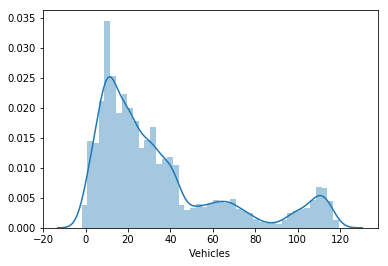

In [21]:
test_new['Vehicles'] = test_new['trend'] + lgb_preds
sns.distplot(test_new['Vehicles'])
plt.show()

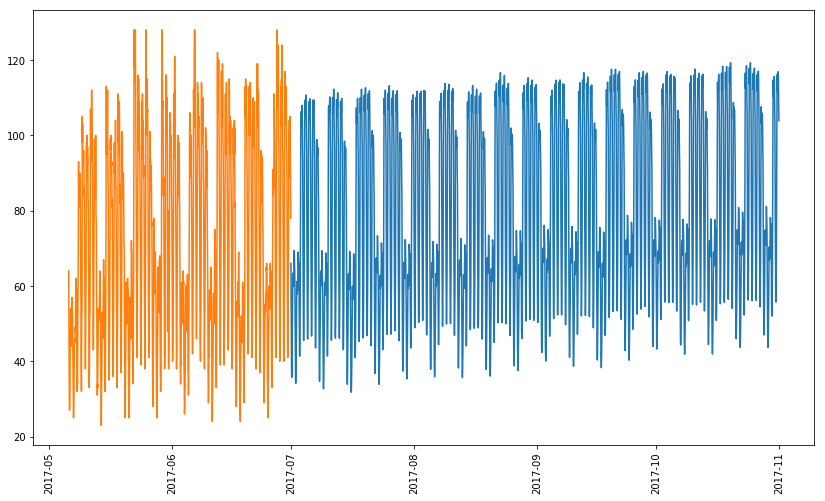

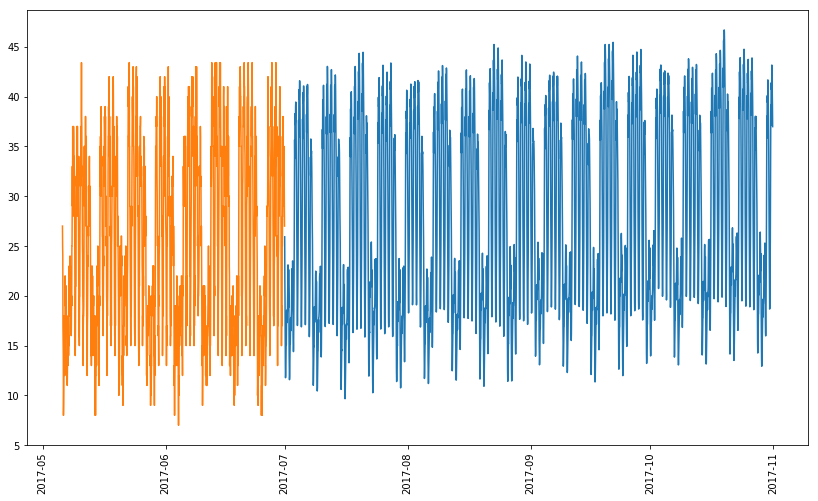

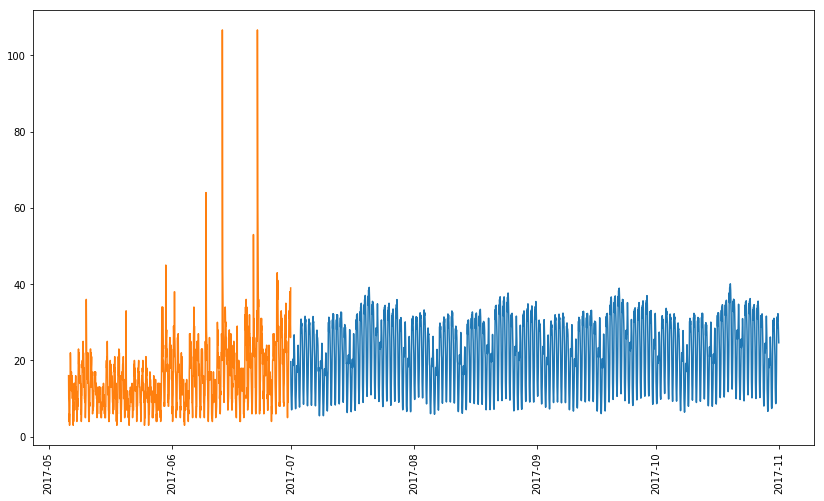

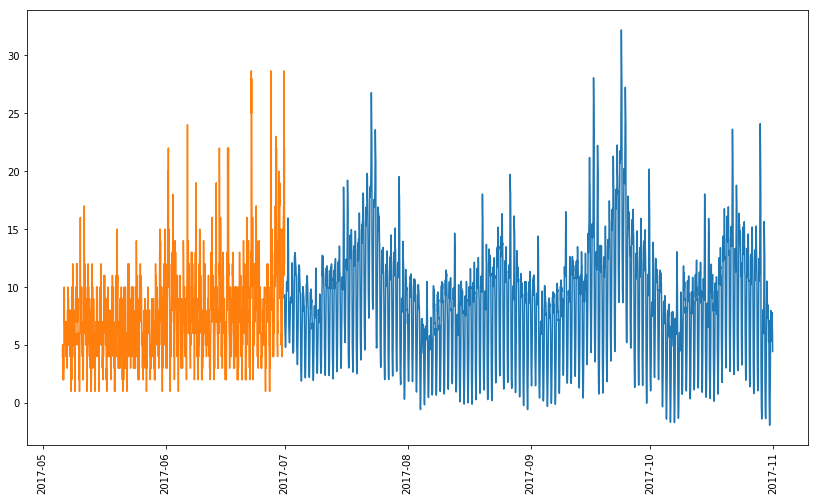

In [22]:
#plot timeseries
def plot_ts(train, test):
    #Whole series
    plt.figure(figsize=(14,8))
    plt.plot(test.set_index('DateTime').Vehicles)

    plt.plot(train.set_index('DateTime').Vehicles.iloc[-7*8*24:])
    plt.xticks(rotation=90)
    plt.show()
    
for jn in [1,2,3,4]:
    plot_ts(train_new.loc[train_new.Junction == jn], test_new.loc[test_new.Junction == jn])

In [23]:
submission_df = test_new[['ID', 'Vehicles']]
submission_df.head()

,ID,Vehicles
0,20170701001,66.007620
1,20170701011,58.340995
2,20170701021,48.835334
3,20170701031,41.772533
4,20170701041,36.825416


In [24]:
submission_df.to_csv("../utility/detrend_lgb_v1.csv", index=False)